# Upload images

We are working with MRI images. The images were obtained from Kaggle (https://www.kaggle.com/datasets)

Suggested course: https://www.udemy.com/share/104Yle3@O_YEUhppyRt5c9rx35o4ZEOSSoa4vbEuz_-ow1jiI7jIRxDs-_zURuthXwyu2-VMmQ==/

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile
!unzip "/content/gdrive/MyDrive/ColabNotebooks_PegahKhosravi/Summer_2023/Data_Brain.zip" -d data

In [3]:
!rm -rf '/content/data/__MACOSX'

In [4]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [5]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
print(device)

cuda


In [7]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [8]:
#Dataloader

#Path for training and validation directory
train_path="/content/data/Data_Brain/training"
validation_path="/content/data/Data_Brain/validation"

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=128, shuffle=True
)
validation_loader=DataLoader(
    torchvision.datasets.ImageFolder(validation_path,transform=transformer),
    batch_size=64, shuffle=True
)

In [17]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [18]:
!rm "/content/data/Data_Brain/validation/.DS_Store"

rm: cannot remove '/content/data/Data_Brain/validation/.DS_Store': No such file or directory


In [19]:
print(classes)

['NoTumor', 'Tumor']


In [20]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [21]:
# March 17 by here
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (256,3,150,150)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)


        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)



        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)


        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)



        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)


            #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)


        output=self.fc(output)

        return output

In [22]:
model=ConvNet(num_classes=2).to(device)

In [23]:
from torch.optim.rmsprop import RMSprop
#Optmizer and loss function
optimizer=RMSprop(model.parameters(),lr=0.0001,weight_decay=0.00001)
loss_function=nn.CrossEntropyLoss()

In [24]:
num_epochs=10

In [25]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.png'))
validation_count=len(glob.glob(validation_path+'/**/*.png'))
#test_count=len(glob.glob(test_path+'/**/*.png'))

In [26]:
print(train_count,validation_count)

838 60


In [27]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):

    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0

    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        optimizer.zero_grad()

        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()


        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))

    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count


    # Evaluation on testing dataset
    model.eval()

    validation_accuracy=0.0
    for i, (images,labels) in enumerate(validation_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        validation_accuracy+=int(torch.sum(prediction==labels.data))

    validation_accuracy=validation_accuracy/validation_count


    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Validation Accuracy: '+str(validation_accuracy))

    #Save the best model
    if validation_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=validation_accuracy

Epoch: 0 Train Loss: tensor(15.6452) Train Accuracy: 0.6157517899761337 Validation Accuracy: 0.5666666666666667
Epoch: 1 Train Loss: tensor(3.6145) Train Accuracy: 0.7219570405727923 Validation Accuracy: 0.5
Epoch: 2 Train Loss: tensor(3.3026) Train Accuracy: 0.7183770883054893 Validation Accuracy: 0.5
Epoch: 3 Train Loss: tensor(1.6841) Train Accuracy: 0.788782816229117 Validation Accuracy: 0.6
Epoch: 4 Train Loss: tensor(1.8109) Train Accuracy: 0.7350835322195705 Validation Accuracy: 0.55
Epoch: 5 Train Loss: tensor(0.4372) Train Accuracy: 0.8842482100238663 Validation Accuracy: 0.75
Epoch: 6 Train Loss: tensor(0.2451) Train Accuracy: 0.9272076372315036 Validation Accuracy: 0.8166666666666667
Epoch: 7 Train Loss: tensor(0.4174) Train Accuracy: 0.8782816229116945 Validation Accuracy: 0.6166666666666667
Epoch: 8 Train Loss: tensor(0.6420) Train Accuracy: 0.8365155131264916 Validation Accuracy: 0.6
Epoch: 9 Train Loss: tensor(0.3636) Train Accuracy: 0.9009546539379475 Validation Accurac

In [28]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2

In [29]:
train_path="/content/data/Data_Brain/training"
pred_path="/content/data/Data_Brain/test"

In [30]:
test_count=len(glob.glob(pred_path+'/*.png'))

In [31]:
print(test_count)

50


In [32]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [33]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (256,3,150,150)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)


        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)



        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)


        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)



        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)


            #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)


        output=self.fc(output)

        return output

In [34]:
checkpoint=torch.load("best_checkpoint.model")
model=ConvNet(num_classes=2)
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=2, bias=True)
)

In [35]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [36]:
#prediction function
def prediction(img_path,transformer):

    image=Image.open(img_path)

    image_tensor=transformer(image).float()


    image_tensor=image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor.cuda()

    input=Variable(image_tensor)


    output=model(input)

    index=output.data.numpy().argmax()

    pred=classes[index]

    return pred

In [37]:
images_path=glob.glob(pred_path+'/*.png')

In [38]:
pred_dict={}

for i in images_path:
    pred_dict[i[i.rfind('/')+1:]]=prediction(i,transformer)

In [39]:
pred_dict

{'N_2_NoTumor_98.png': 'Tumor',
 'T_YesTumor04.png': 'Tumor',
 'N_NoTumor_2.png': 'NoTumor',
 'T_GliomaTumor_20.png': 'Tumor',
 'T_GliomaTumor_24.png': 'Tumor',
 'N_NoTumor_8.png': 'NoTumor',
 'N_NoTumor_6.png': 'NoTumor',
 'T_Tr_PituitaryTumor_796.png': 'Tumor',
 'N_NoTumor33.png': 'NoTumor',
 'T_Tr_PituitaryTumor_740.png': 'Tumor',
 'T_GliomaTumor_66.png': 'Tumor',
 'N_NoTumor30.png': 'Tumor',
 'N_NoTumor_18.png': 'Tumor',
 'N_NoTumor_13.png': 'NoTumor',
 'T_Tr_PituitaryTumor_783.png': 'Tumor',
 'N_NoTumor_4.png': 'Tumor',
 'T_MeningiomaTumor_3.png': 'NoTumor',
 'T_YesTumor01.png': 'Tumor',
 'N_NoTumor_1.png': 'NoTumor',
 'N_2_PituitaryTumor_22.png': 'Tumor',
 'T_YesTumor05.png': 'Tumor',
 'N_NoTumor32.png': 'NoTumor',
 'T_YesTumor02.png': 'NoTumor',
 'T_GliomaTumor_18.png': 'NoTumor',
 'T_MeningiomaTumor_2.png': 'Tumor',
 'N_2_PituitaryTumor_564.png': 'Tumor',
 'T_MeningiomaTumor_.png': 'NoTumor',
 'N_2_NoTumor_76.png': 'Tumor',
 'T_MeningiomaTumor_17.png': 'Tumor',
 'T_Tr_Pituitary

In [40]:
import csv

output_dict = {'N_2_NoTumor_98.png': 'Tumor',
 'T_YesTumor04.png': 'Tumor',
 'N_NoTumor_2.png': 'NoTumor',
 'T_GliomaTumor_20.png': 'Tumor',
 'T_GliomaTumor_24.png': 'Tumor',
 'N_NoTumor_8.png': 'NoTumor',
 'N_NoTumor_6.png': 'NoTumor',
 'T_Tr_PituitaryTumor_796.png': 'Tumor',
 'N_NoTumor33.png': 'NoTumor',
 'T_Tr_PituitaryTumor_740.png': 'Tumor',
 'T_GliomaTumor_66.png': 'Tumor',
 'N_NoTumor30.png': 'Tumor',
 'N_NoTumor_18.png': 'Tumor',
 'N_NoTumor_13.png': 'NoTumor',
 'T_Tr_PituitaryTumor_783.png': 'Tumor',
 'N_NoTumor_4.png': 'Tumor',
 'T_MeningiomaTumor_3.png': 'NoTumor',
 'T_YesTumor01.png': 'Tumor',
 'N_NoTumor_1.png': 'NoTumor',
 'N_2_PituitaryTumor_22.png': 'Tumor',
 'T_YesTumor05.png': 'Tumor',
 'N_NoTumor32.png': 'NoTumor',
 'T_YesTumor02.png': 'NoTumor',
 'T_GliomaTumor_18.png': 'NoTumor',
 'T_MeningiomaTumor_2.png': 'Tumor',
 'N_2_PituitaryTumor_564.png': 'Tumor',
 'T_MeningiomaTumor_.png': 'NoTumor',
 'N_2_NoTumor_76.png': 'Tumor',
 'T_MeningiomaTumor_17.png': 'Tumor',
 'T_Tr_PituitaryTumor_795.png': 'Tumor',
 'N_NoTumor31.png': 'NoTumor',
 'T_GliomaTumor_67.png': 'Tumor',
 'N_2_PituitaryTumor_638.png': 'Tumor',
 'T_GliomaTumor_78.png': 'NoTumor',
 'T_GliomaTumor_3.png': 'NoTumor',
 'N_2_PituitaryTumor_628.png': 'Tumor',
 'N_2_NoTumor_89.png': 'NoTumor',
 'N_NoTumor_14.png': 'NoTumor',
 'T_GliomaTumor_76.png': 'Tumor',
 'T_GliomaTumor_8.png': 'Tumor',
 'T_Tr_PituitaryTumor_784.png': 'Tumor',
 'T_GliomaTumor_75.png': 'Tumor',
 'N_NoTumor_3.png': 'NoTumor',
 'N_2_NoTumor_71.png': 'Tumor',
 'N_2_PituitaryTumor_21.png': 'Tumor',
 'N_NoTumor_12.png': 'Tumor',
 'N_2_NoTumor_103.png': 'NoTumor',
 'N_NoTumor34.png': 'Tumor',
 'T_MeningiomaTumor_7.png': 'Tumor',
 'T_YesTumor03.png': 'Tumor'}

# open file
with open("filename.csv", "w") as file:
    csvwriter = csv.writer(file)

    # write header to file
    csvwriter.writerow(["Label", "Predict"])

    # write results to csv
    for key in output_dict.keys():
        row = ""
        if key[0] == "N":
            row+="1"
        else:
            row+="0"
        if output_dict[key] == "NoTumor":
            row+="1"
        else:
            row+="0"
        csvwriter.writerow(row)

In [41]:
from torchsummary import summary

model=model.cuda()

summary(model, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 150, 150]             336
       BatchNorm2d-2         [-1, 12, 150, 150]              24
              ReLU-3         [-1, 12, 150, 150]               0
         MaxPool2d-4           [-1, 12, 75, 75]               0
            Conv2d-5           [-1, 20, 75, 75]           2,180
              ReLU-6           [-1, 20, 75, 75]               0
            Conv2d-7           [-1, 32, 75, 75]           5,792
       BatchNorm2d-8           [-1, 32, 75, 75]              64
              ReLU-9           [-1, 32, 75, 75]               0
           Linear-10                    [-1, 2]         360,002
Total params: 368,398
Trainable params: 368,398
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 12.53
Params size (MB): 1.41
Estimated 

In [42]:
import pandas as pd
import numpy as np
import pylab as pl
from sklearn.metrics import roc_curve, auc

In [43]:
df = pd.read_csv('filename.csv')

y_test = np.array(df)[:,0]
probas = np.array(df)[:,1]

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.620000


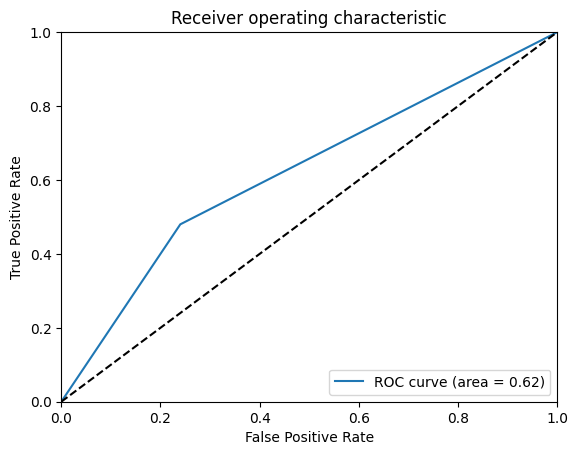

In [44]:
# Plot ROC curve
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

In [45]:
import pandas as pd
data=pd.read_csv("/content/filename.csv")
data.head(10)

,Label,Predict
0,1,0
1,0,0
2,1,1
3,0,0
4,0,0
5,1,1
6,1,1
7,0,0
8,1,1
9,0,0


In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score
results = confusion_matrix(data['Label'], data['Predict'])
print(results)
accuracy_score(data['Label'], data['Predict'])

[[19  6]
 [13 12]]


0.62

In [47]:
true_neg, false_pos, false_neg, true_pos = results.ravel()
true_neg, false_pos, false_neg, true_pos

(19, 6, 13, 12)

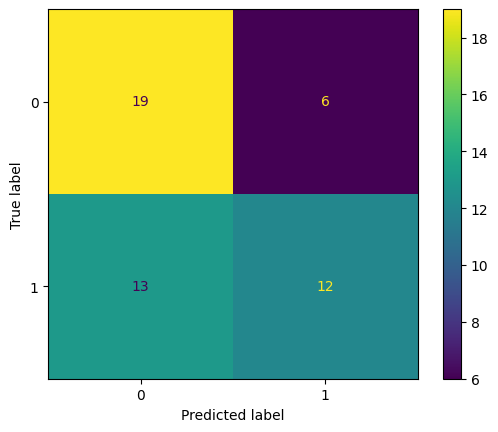

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(results).plot()